In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from scipy.integrate import solve_ivp
%matplotlib inline
import Optimisation
from importlib import reload
reload(Optimisation)
from Optimisation import *


from cpclasses import save_animation

In [2]:
class LennardJones(Potential):

    def __init__(self, eps0 = 5, sigma = 2**(-1/6), x_range = [0.8, 2], kT = 0.15, N_bins = 40):
        self.eps0 = eps0
        self.sigma = sigma
        self.type = 'Lennard-Jones'
        super().__init__( type = self.type, x_range = x_range, kT = kT, N_bins=N_bins)

    def _V(self, distance):
        V = 4*self.eps0*((self.sigma/distance)**12 - (self.sigma/distance)**6)
        return V

    def _dV_dr(self, r):
        dV_dr = 4*self.eps0*(-12*(self.sigma/r)**13 + 6*(self.sigma/r)**7)
        return dV_dr

    def energy(self, positions): 
        return np.sum(self._V(pdist(positions)))

    def V(self, positions): 
        return np.sum(self._V(pdist(positions)))

    def force(self, pos):
        diff = pos[np.newaxis, :, :] - pos[:, np.newaxis, :]
        r = np.sqrt(np.sum(diff**2, axis=-1))
        np.fill_diagonal(r, np.inf)
        force_magnitude = self._dV_dr(r)
        forces = np.sum(force_magnitude[..., np.newaxis] * diff / \
                        r[..., np.newaxis], axis=1)
        return forces

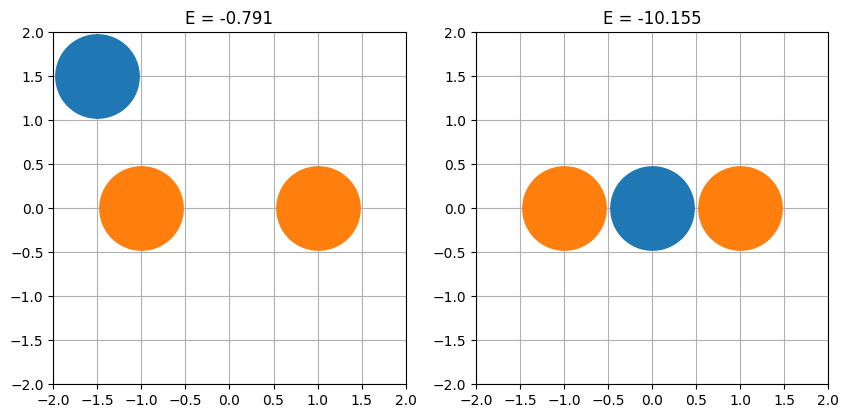

In [3]:
#Define three points:
static_points= np.array([[-1, 0], [1,0]])
points = np.array([[-1, 0], [1,0], [-1.5, 1.5]])
points2 = np.array([[-1, 0], [1,0], [0,0]])

LJ_Potential = LennardJones()


fig, ax = plt.subplots(1,2, figsize = (10,5))

for point, ax in zip([points, points2], ax):
    ax.plot(point[-1,0], point[-1,1], 'o', ms = 60)
    ax.plot(point[:2,0], point[:2,1],'o', ms = 60)
    ax.set_xlim(-2,2)
    ax.set_ylim(-2,2)
    ax.set_aspect('equal')
    ax.grid(zorder = 10)
    LJ_Potential.energy(point)
    ax.set_title(f'E = {LJ_Potential.energy(point):.3f}')




In [4]:
static_points= np.array([[-1, 0], [1,0]])
x = np.linspace(-2,2,400)
y = np.linspace(-2,2,400)

Xs, Ys = np.meshgrid(x,y)

Zs = np.zeros_like(Xs)
for i in range(len(x)):
    for j in range(len(y)):
        Zs[i,j] = LJ_Potential.energy(np.array([[Xs[i,j], Ys[i,j]], static_points[0], static_points[1]]))
        if Zs[i,j] > 0:
            Zs[i,j] = 0



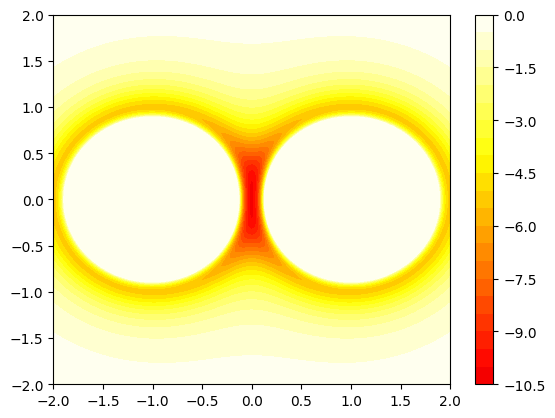

In [5]:
fig, ax = plt.subplots()
contour = ax.contourf(Xs, Ys, Zs, vmin = -15.75, vmax = 0, cmap = 'hot', levels = 20, extent=[-0.5, 0.5, -0.5, 0.5]) 
plt.colorbar(contour)


Accepted 72 out of 250 samples: 28.8% acceptance rate


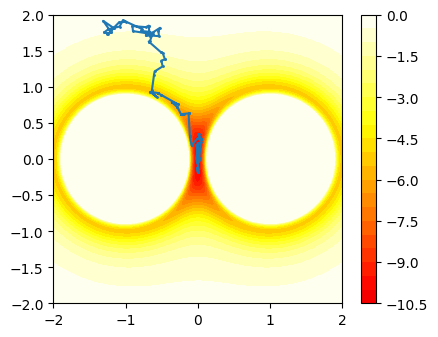

In [58]:
LJ_Potential = LennardJones()

LJ_Potential.mcmc_deltax = 0.1

initial_point = np.array([-1, 1.9])

LJ_Potential.sample_MCMC( 250, initial_point=initial_point, static_points = static_points)

fig, ax = plt.subplots(1,1, figsize = (5,3.75))

ax.plot(LJ_Potential.mcmc[:,0], LJ_Potential.mcmc[:,1], '-o', ms = 1)
contour = ax.contourf(Xs, Ys, Zs, vmin = -15.75, vmax = 0, cmap = 'hot', levels = 20, extent=[-0.5, 0.5, -0.5, 0.5]) 
plt.colorbar(contour)
ax.set_aspect('equal')




In [59]:
def remove_duplicates(arr):
    seen = set()
    result = []
    for item in arr:
        if item[0] not in seen:
            seen.add(item[0])
            result.append(item)
    return result

points = np.array(remove_duplicates(LJ_Potential.mcmc))

print(f'Number of unique points: {len(points)}')

Number of unique points: 73


In [62]:
ax.clear()
ax.contourf(Xs, Ys, Zs, vmin = -15.75, vmax = 0, cmap = 'hot', levels = 20, extent=[-0.5, 0.5, -0.5, 0.5])
#plt.colorbar(contour, ax = ax)
ax.set_aspect('equal')
ax.grid(zorder = 10)
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)


def update(i):
    ax.plot(points[:i, 0], points[:i,1], '-o', ms = 1, color = 'C0')
    fig.tight_layout()
    


frames = len(points)

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

fig
ani = animation.FuncAnimation(fig, update, frames=frames, repeat=False)

#ani.save('mcmc.gif', writer='ffmpeg', fps=15)
save_animation(ani, 'mcmc.gif', writer = 'ffmpeg', fps = 15)

<Figure size 640x480 with 0 Axes>

In [8]:
print(len(LJ_Potential.mcmc))

249


In [23]:
#print(LJ_Potential.mcmc)

#Remove duplicates:
LJ_Potential.mcmc = np.unique(LJ_Potential.mcmc, axis = 0)

print(LJ_Potential.mcmc)

[[-1.50418532  0.88734887]
 [-1.43782578  0.91703719]
 [-1.39881223  0.8795935 ]
 [-1.33088604  1.91997613]
 [-1.32151176  0.9556133 ]
 [-1.32022573  0.93916685]
 [-1.26559882  2.01346224]
 [-1.22781312  2.12012954]
 [-1.21968657  1.86878609]
 [-1.20148854  0.99717856]
 [-1.18883002  1.89354418]
 [-1.16983072  0.9858534 ]
 [-1.15757149  1.00236214]
 [-1.14390076  1.02116   ]
 [-1.13204923  0.99575977]
 [-1.10445084  1.02698914]
 [-1.07838981  1.02407821]
 [-1.07126855  1.00828785]
 [-1.06839875  0.98485447]
 [-1.05237785  0.99432018]
 [-1.03781951  1.01121985]
 [-1.02174799  0.98653602]
 [-0.99565274  0.98525909]
 [-0.99496585  0.99955014]
 [-0.97940812  1.93368656]
 [-0.94890698  1.00850815]
 [-0.93977849  1.02838204]
 [-0.93915122  0.97996307]
 [-0.93369265  1.00803896]
 [-0.9202908   1.00370762]
 [-0.91572634  1.00363388]
 [-0.91530681  2.13590164]
 [-0.91396411  2.07718137]
 [-0.90220125  0.98912751]
 [-0.88822119  0.9510984 ]
 [-0.8710436   1.01852515]
 [-0.86686811  0.98076119]
 